# Check solve_kolmogorov 2

In [1]:
import numpy as np
import matplotlib.pylab as plt

import itertools
import pandas as pd

import sys
sys.path.append('../src/')
import solve_kolmogorov
import simulate_gillespie
import Hypergraphs

from scipy.integrate import solve_ivp

from scipy.special import comb

In [2]:
"""Complete case test."""
run_gillespie_simulations = False
if run_gillespie_simulations: 
    for N in [100, 200]: # 500 takes too long
        file_path = f"../results/sim_results_{N}.npz"
        # setup
        nsims = 10 # number of simulation runs
        time_max = 10   # maximum time duration

        # N = 100
        g = Hypergraphs.CompleteHypergraph(N)

        I0 = int(N * 0.1) # number of initial infected = 10 percent
        initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

        beta1 = 2 / N       # pairwise infection rate
        beta2 = 4 / (N**2)  # hyperedge contagion rate
        mu    = 1           # recovery rate

        print(f"Setup: \n")
        print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
        print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")
        
        X_sims = []
        for _ in range(nsims):
            X_t = simulate_gillespie.gillespie_sim(
                g, beta1, beta2, mu, initial_infections, time_max)
            X_sims.append(X_t)

        # save the simulation results
        sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
        np.savez_compressed(file_path, **sim_results)
        print(f"Saved to {file_path}")

Setup: 

	H = CompleteHypergraph, N = 200, I0 = 20

	beta1 = 0.01, beta2 = 0.0001, mu = 1



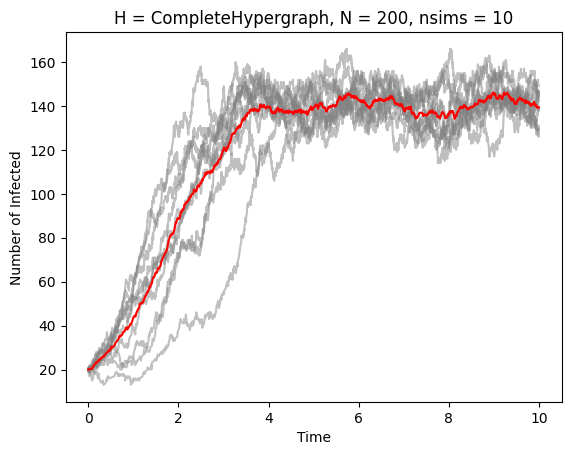

In [4]:
# load simulation results
# setup
nsims = 10 # number of simulation runs
time_max = 10   # maximum time duration

N = 200
g = Hypergraphs.CompleteHypergraph(N)

I0 = int(N * 0.1) # number of initial infected = 10 percent
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

file_path = f"../results/sim_results_{N}.npz"
sim_results = np.load(file_path, allow_pickle=True)
X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]    

# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()
for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)
avg_curve, times = simulate_gillespie.get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# plt.savefig("../figures/solutions-kolmogorov/complete/gillespie-sims.pdf", 
#             format='pdf', bbox_inches='tight')
plt.show()

In [5]:
# solve KEs and compare
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)
ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

# solve ode_system_complete over time
# e.g. from 0 to 10
t_span = (0.0, 10.0)

# times t_i to evaluate in, get saved in sol.t
t_eval = np.linspace(t_span[0], t_span[1], 101)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="RK45"
)

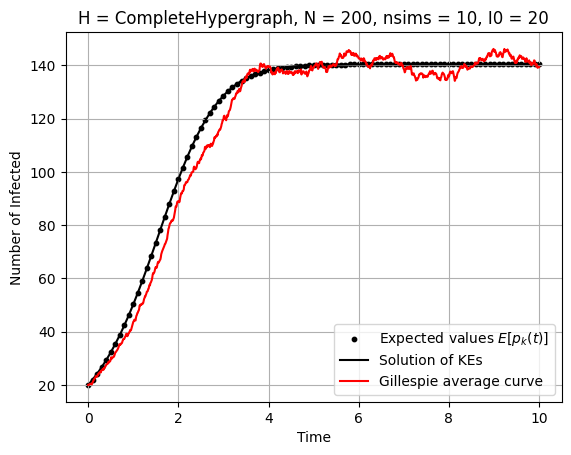

In [8]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = solve_kolmogorov.calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, color="k",
            label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig("../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg-200.pdf", 
            format='pdf', bbox_inches='tight') 
plt.show()

## N = 100

In [11]:
"""Complete case test."""
# setup
nsims = 10 # number of simulation runs
time_max = 10   # maximum time duration


N = 100
g = Hypergraphs.CompleteHypergraph(N)

I0 = 20 # number of initial infected
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = CompleteHypergraph, N = 100, I0 = 20

	beta1 = 0.02, beta2 = 0.0004, mu = 1



In [12]:
run_gillespie_simulations = True
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = simulate_gillespie.gillespie_sim(
            g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed('../results/sim_results_N=100_I0=20.npz', **sim_results)
else:
    # load simulation results
    sim_results = np.load('../results/sim_results_N=100_I0=20.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

exited while loop: time=10.003719722369341, time_to_event=0.006011217582172794
exited while loop: time=10.00515564200561, time_to_event=0.007750268411815629
exited while loop: time=10.00795140497685, time_to_event=0.016498047748614658
exited while loop: time=10.005048060788113, time_to_event=0.0075618009363377274
exited while loop: time=10.01186765722888, time_to_event=0.02519655163017809
exited while loop: time=10.002046262039004, time_to_event=0.00837846170591375
exited while loop: time=10.000492446999871, time_to_event=0.001109958532762404
exited while loop: time=10.003743960616493, time_to_event=0.00487917468942814
exited while loop: time=10.008391031203198, time_to_event=0.014129429366319427
exited while loop: time=10.003681928894197, time_to_event=0.007825564051475654


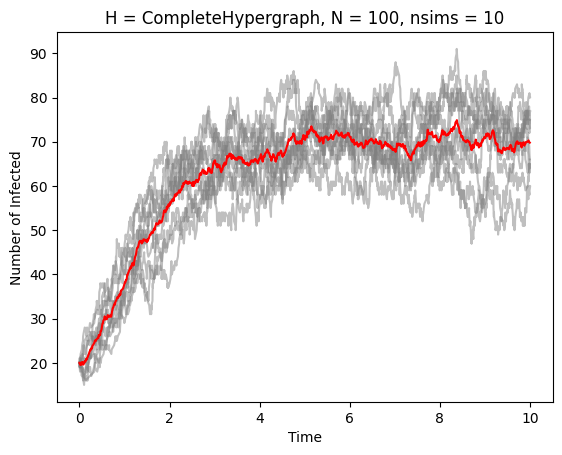

In [13]:
# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()
for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)
avg_curve, times = simulate_gillespie.get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# plt.savefig("../figures/solutions-kolmogorov/complete/gillespie-sims.pdf", 
#             format='pdf', bbox_inches='tight')
plt.show()

In [14]:
# solve KEs and compare
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)
ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

# solve ode_system_complete over time
# e.g. from 0 to 10
t_span = (0.0, 10.0)

# times t_i to evaluate in, get saved in sol.t
t_eval = np.linspace(t_span[0], t_span[1], 101)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="RK45"
)

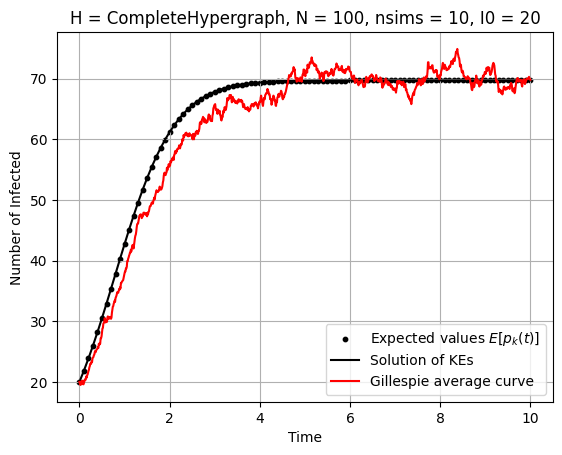

In [15]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = solve_kolmogorov.calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, color="k",
            label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig(f"../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg_N={N}_I0={I0}.pdf", 
            format='pdf', bbox_inches='tight') 
plt.show()